In [85]:
import boto3
import diff_classifier.aws as aws
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

from matplotlib import colors as plt_colors

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import shap

In [ ]:
!pwd

In [ ]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

In [ ]:
dataset_path = workbookDir + '/raw_data_age/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]


In [ ]:
filelist

In [ ]:
#For regression analysis, want all age groups

fstats_tot = None
video_num = 0
for filename in filelist:
    try:
        fstats = pd.read_csv(dataset_path + filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        if 'P14' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[14], index=fstats.index)
        elif 'P21' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[21], index=fstats.index)
        elif 'P28' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[28], index=fstats.index)
        elif 'NT_brain_2' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[35], index=fstats.index)
        #elif 'P70' in filename:
            #fstats['age'] = pd.Series(fstats.shape[0]*[70], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[video_num], index=fstats.index)
        if fstats_tot is None:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        video_num += 1
    except Exception:
            print('Skipped!: {}'.format(filename))

In [ ]:
fstats_tot.head()

DATA ANALYSIS

In [ ]:
fstats_tot.columns


In [84]:
fstats_tot
features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    'angle_mag_mean', # Magnitude of the turning angle mean
    'angle_var', # Variance of the turning angle
    'dist_tot', # Total distance of the trajectory
    'dist_net', # Net distance from first point to last point
    'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1',
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

# shap_features = [
#     'Mean Deff1',
#     'Mean D_fit',
#     'Mean fractal_dim',
#     'Mean MSD_ratio',
#     'Mean kurtosis',
#     'Mean straightness'
#     ]

target = 'age'           # prediction target (y)

ecm = fstats_tot
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points

In [101]:
ecm.head()

,AR,D_fit,Deff1,Deff2,MSD_ratio,Mean_Intensity,Quality,SN_Ratio,Track_ID,X,...,Std convex_hull,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression,age
0,1.377828,1.466714,0.345123,NaN,0.347071,273.081589,11.597396,1.247060,0.0,456.755044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.844000,34.234700,9.878498,NaN,0.441034,323.044089,13.495678,1.452336,1.0,307.691753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.022024,0.283085,1.399129,NaN,-0.040681,273.148417,9.537690,1.049243,2.0,240.963795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.448351,0.000021,1.842264,NaN,0.003731,313.467054,13.555223,1.444834,3.0,209.178269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.441644,0.054312,2.066218,0.36868,0.017288,278.409074,13.849725,1.172745,4.0,213.264787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def balance_data(df, target, **kwargs):
    if 'random_state' not in kwargs:
        random_state = 1
    else:
        random_state = kwargs['random_state']
    df_target = []
    bal_df = []
    for name in df[target].unique():
        if name > 0: # Needed to do remove nan as a name
            df_target.append((name, df[df[target] == name]))
    print(f"Ratio before data balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i[1])) for i in df_target])}")
    for i in range(len(df_target)):
        #print(len(df_target[i][1]))
        ratio = min([len(i[1]) for i in df_target])/len(df_target[i][1])
        bal_df.append(df_target[i][1].sample(frac=ratio, random_state=random_state))
    print(f"Ratio after balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i)) for i in bal_df])}")
    return pd.concat(bal_df)
bal_ecm = balance_data(ecm, target, random_state=1)

BINNING OF DATA

In [ ]:
resolution = 128
assert not 2048%resolution and resolution >= 128, "resolution needs to be a factor of 2048 and > 128"
bins = list(range(0, 2048+1, resolution))
bin_labels = [int(i/resolution) for i in bins][:-1]
bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=bin_labels, include_lowest=True)
bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=bin_labels, include_lowest=True)
bal_ecm['bins'] = (len(bins)-1)*bal_ecm['binx'].astype(np.int32) + bal_ecm['biny'].astype(np.int32)
bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
bal_ecm['bins'] = bal_ecm['bins'].astype(int)

In [89]:
# Regular split of data
seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

#le = preprocessing.LabelEncoder()
#bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

# y_train = X_train['encoded_target']
# y_test = X_test['encoded_target']
# y_val = X_val['encoded_target']

y_train = X_train['age']
y_test = X_test['age']
y_val = X_val['age']

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [ ]:
def get_lengths(df, X_train, X_test, X_val=None):
    print(f'Tot before split: {len(df)}')
    print(f'Training: {len(X_train)} ({len(X_train)/len(bal_ecm):.3f}%)')
    print(f'Testing: {len(X_test)} ({len(X_test)/len(bal_ecm):.3f}%)')
    try:
        print(f'Evaluation: {len(X_val)} ({len(X_val)/len(bal_ecm):.3f}%)')
    except:
        pass
get_lengths(bal_ecm, X_train, X_test, X_val)

MODELLING

In [67]:
# Build Baseline Model
mean_train = y_train.mean() # Mean of training data
baseline_predictions = np.ones(y_test.shape) * mean_train #baseline predictions using mean
mae_baseline = metrics.mean_absolute_error(y_test, baseline_predictions)
mse_baseline = metrics.mean_squared_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))
print("Baseline MSE is {:.2f}".format(mse_baseline))

Baseline MAE is 6.99
Baseline MSE is 61.10


In [ ]:
# Set initial parameters
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'reg:linear',
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mae"
        }

In [ ]:
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException

def cv(params, X_train, y_train, features=None, num_boost_round=20, nfold=3, stratified=False, folds=None,
       metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None,
       fpreproc=None, as_pandas=True, verbose_eval=100, show_stdv=True,
       seed=0, callbacks=None, shuffle=True):
    # pylint: disable = invalid-name
    """Cross-validation with given parameters.

    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round : int
        Number of boosting iterations.
    nfold : int
        Number of folds in CV.
    stratified : bool
        Perform stratified sampling.
    folds : a KFold or StratifiedKFold instance or list of fold indices
        Sklearn KFolds or StratifiedKFolds object.
        Alternatively may explicitly pass sample indices for each fold.
        For ``n`` folds, **folds** should be a length ``n`` list of tuples.
        Each tuple is ``(in,out)`` where ``in`` is a list of indices to be used
        as the training samples for the ``n`` th fold and ``out`` is a list of
        indices to be used as the testing samples for the ``n`` th fold.
    metrics : string or list of strings
        Evaluation metrics to be watched in CV.
    obj : function
        Custom objective function.
    feval : function
        Custom evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. Cross-Validation metric (average of validation
        metric computed over CV folds) needs to improve at least once in
        every **early_stopping_rounds** round(s) to continue training.
        The last entry in the evaluation history will represent the best iteration.
        If there's more than one metric in the **eval_metric** parameter given in
        **params**, the last metric will be used for early stopping.
    fpreproc : function
        Preprocessing function that takes (dtrain, dtest, param) and returns
        transformed versions of those.
    as_pandas : bool, default True
        Return pd.DataFrame when pandas is installed.
        If False or pandas is not installed, return np.ndarray
    verbose_eval : bool, int, or None, default None
        Whether to display the progress. If None, progress will be displayed
        when np.ndarray is returned. If True, progress will be displayed at
        boosting stage. If an integer is given, progress will be displayed
        at every given `verbose_eval` boosting stage.
    show_stdv : bool, default True
        Whether to display the standard deviation in progress.
        Results are not affected, and always contains std.
    seed : int
        Seed used to generate the folds (passed to numpy.random.seed).
    callbacks : list of callback functions
        List of callback functions that are applied at end of each iteration.
        It is possible to use predefined callbacks by using
        :ref:`Callback API <callback_api>`.
        Example:

        .. code-block:: python

            [xgb.callback.reset_learning_rate(custom_rates)]
    shuffle : bool
        Shuffle data before creating folds.

    Returns
    -------
    evaluation history : list(string)
    """
    if stratified is True and not SKLEARN_INSTALLED:
        raise XGBoostError('sklearn needs to be installed in order to use stratified cv')
    if isinstance(metrics, str):
        metrics = [metrics]
    if not features:
        features = X_train.columns
    if isinstance(params, list):
        _metrics = [x[1] for x in params if x[0] == 'eval_metric']
        params = dict(params)
        if 'eval_metric' in params:
            params['eval_metric'] = _metrics
    else:
        params = dict((k, v) for k, v in params.items())
    if (not metrics) and 'eval_metric' in params:
        if isinstance(params['eval_metric'], list):
            metrics = params['eval_metric']
        else:
            metrics = [params['eval_metric']]
    params.pop("eval_metric", None)
    results = {}
    # create folds in data
    cvfolds, wt_list = mknfold(X_train, y_train, nfold, params, metrics, features)
    
    # setup callbacks
    callbacks = [] if callbacks is None else callbacks
    if early_stopping_rounds is not None:
        callbacks.append(callback.early_stop(early_stopping_rounds,
                                             maximize=maximize,
                                             verbose=False))
    if isinstance(verbose_eval, bool) and verbose_eval:
        callbacks.append(callback.print_evaluation(show_stdv=show_stdv))
    elif isinstance(verbose_eval, int):
        callbacks.append(callback.print_evaluation(verbose_eval, show_stdv=show_stdv))
    callbacks_before_iter = [
        cb for cb in callbacks if
        cb.__dict__.get('before_iteration', False)]
    callbacks_after_iter = [
        cb for cb in callbacks if
        not cb.__dict__.get('before_iteration', False)]
    for i in range(num_boost_round):
        for cb in callbacks_before_iter:
            cb(CallbackEnv(model=None,
                           cvfolds=cvfolds,
                           iteration=i,
                           begin_iteration=0,
                           end_iteration=num_boost_round,
                           rank=0,
                           evaluation_result_list=None))
        for fold in cvfolds:
            fold.update(i, obj)
        res = aggcv([f.eval(i, feval) for f in cvfolds], wt_list)
        for key, mean, std in res:
            if key + '-mean' not in results:
                results[key + '-mean'] = []
            if key + '-std' not in results:
                results[key + '-std'] = []
            results[key + '-mean'].append(mean)
            results[key + '-std'].append(std)
        try:
            for cb in callbacks_after_iter:
                cb(CallbackEnv(model=None,
                               cvfolds=cvfolds,
                               iteration=i,
                               begin_iteration=0,
                               end_iteration=num_boost_round,
                               rank=0,
                               evaluation_result_list=res))
        except EarlyStopException as e:
            for k in results:
                results[k] = results[k][:(e.best_iteration + 1)]
            break
    
    if as_pandas:
        try:
            import pandas as pd
            results = pd.DataFrame.from_dict(results)
        except ImportError:
            pass
    return results

In [ ]:
def bin_fold(X_train, nfold):
    bin_list = [X_train[X_train['bins'] == i_bin].index.to_numpy() for i_bin in X_train.bins.unique()]
    bin_list = sorted(bin_list, key=len)
    i = 0
    while(len(bin_list) > nfold):
        if (i >= len(bin_list)-1):
            i = 0
        bin_list[i] = np.concatenate([bin_list[i], bin_list.pop()])
        i += 1
    wt_list = [len(i)/sum(len(s) for s in bin_list) for i in bin_list]
    return bin_list, wt_list

def mknfold(X_train, y_train, nfold, param, evals=(), features=None):
    if not features:
        features = X_train.columns
    dall = xgb.DMatrix(X_train[features], label=y_train)
    out_idset, wt_list = bin_fold(X_train, nfold)
    in_idset = [np.concatenate([out_idset[i] for i in range(nfold) if k != i]) for k in range(nfold)]
    evals = list(evals)
    ret = []
    for k in range(nfold):
        # perform the slicing using the indexes determined by the above methods
        x_train_snip = X_train.loc[in_idset[k]][features]
        y_train_snip = X_train.loc[in_idset[k]]['age']        
        x_test_snip = X_train.loc[out_idset[k]][features]
        y_test_snip = X_train.loc[out_idset[k]]['age']
        dtrain = xgb.DMatrix(x_train_snip, label=y_train_snip)
        dtest = xgb.DMatrix(x_test_snip, label=y_test_snip)
        tparam = param
        plst = list(tparam.items()) + [('eval_metric', itm) for itm in evals]
        ret.append(CVPack(dtrain, dtest, plst))
    return ret, wt_list

In [ ]:
from xgboost.core import STRING_TYPES

def aggcv(rlist, wt_list):
    # pylint: disable=invalid-name
    """
    Aggregate cross-validation results.

    If verbose_eval is true, progress is displayed in every call. If
    verbose_eval is an integer, progress will only be displayed every
    `verbose_eval` trees, tracked via trial.
    """
    cvmap = {}
    idx = rlist[0].split()[0]
    for line in rlist:
        arr = line.split()
        assert idx == arr[0]
        for metric_idx, it in enumerate(arr[1:]):
            if not isinstance(it, STRING_TYPES):
                it = it.decode()
            k, v = it.split(':')
            if (metric_idx, k) not in cvmap:
                cvmap[(metric_idx, k)] = []
            cvmap[(metric_idx, k)].append(float(v))
    msg = idx
    results = []
    for (metric_idx, k), v in sorted(cvmap.items(), key=lambda x: x[0][0]):
        v = np.array(v)
        if not isinstance(msg, STRING_TYPES):
            msg = msg.decode()
        mean = np.average(v, weights=wt_list)
        std = np.average((v-mean)**2, weights=wt_list)
        results.extend([(k, mean, std)])
    return results

In [ ]:
cv_results = cv(param, X_train, y_train, features, num_boost_round=2000, nfold=5, early_stopping_rounds=200, metrics={'rmse'})
cv_results

In [ ]:
import operator
import numpy as np

def xgb_paramsearch(X_train, y_train, features, init_params, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics=None, **kwargs):
    params = {**init_params}
    if 'use_gpu' in kwargs and kwargs['use_gpu']:
        # GPU integration will cut cv time in ~half:
        params.update({'gpu_id' : 0,
                       'tree_method': 'gpu_hist',
                       'predictor': 'gpu_predictor'})
    if 'metrics' not in kwargs:
        metrics = {params['eval_metric']}
    else:
        metrics.add(params['eval_metric'])
    if params['eval_metric'] in ['map', 'auc', 'aucpr']:
        eval_f = operator.gt
    else: 
        eval_f = operator.lt
    if 'early_break' not in kwargs:
        early_break = 5
    else: 
        early_break = kwargs['early_break']
    if 'thresh' not in kwargs:
        thresh = 0.01
    else: 
        thresh = kwargs['thresh']
    if 'seed' not in kwargs:
        seed = 1111
    else:
        seed = kwargs['seed']
    best_param = params
    best_model = cv(params, 
                    X_train, 
                    y_train, 
                    features, 
                    nfold=nfold, 
                    num_boost_round=num_boost_round, 
                    early_stopping_rounds=early_stopping_rounds, 
                    metrics=metrics)
    best_eval = best_model[f"test-{params['eval_metric']}-mean"].min()
    best_boost_rounds = best_model[f"test-{params['eval_metric']}-mean"].idxmin()
    
    def _gs_helper(var1n, var2n, best_model, best_param, best_eval, best_boost_rounds):
        local_param = {**best_param}
        for var1, var2 in gs_params:
            print(f"Using CV with {var1n}={{{var1}}}, {var2n}={{{var2}}}")
            local_param[var1n] = var1
            local_param[var2n] = var2
            cv_model = cv(local_param, 
                          X_train, 
                          y_train, 
                          features, 
                          nfold=nfold, 
                          num_boost_round= num_boost_round, 
                          early_stopping_rounds=early_stopping_rounds, 
                          metrics=metrics)
            cv_eval = cv_model[f"test-{local_param['eval_metric']}-mean"].min()
            boost_rounds = cv_model[f"test-{local_param['eval_metric']}-mean"].idxmin()
            if(eval_f(cv_eval, best_eval)):
                best_model = cv_model
                best_param[var1n] = var1
                best_param[var2n] = var2
                best_eval = cv_eval
                best_boost_rounds = boost_rounds
                print(f"New best param found: "
                      f"{local_param['eval_metric']} = {{{best_eval}}}, "
                      f"boost_rounds = {{{best_boost_rounds}}}")
        return best_model, best_param, best_eval, best_boost_rounds
    
    while(early_break >= 0):
        np.random.seed(seed)
        best_eval_init = best_eval
        gs_params = {
            (subsample, colsample)
            for subsample in np.random.choice([i/10. for i in range(5,11)], 3)
            for colsample in np.random.choice([i/10. for i in range(5,11)], 3)
        }
        best_model, best_param, best_eval, best_boost_rounds = _gs_helper('subsample', 
                                                                          'colsample_bytree', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        gs_params = {
            (max_depth, min_child_weight)
            for max_depth in [10] + list(np.random.randint(1, 10, 3))
            for min_child_weight in [0, 10] + list(np.random.randint(0, 10, 3))
        }
        best_model, 
        best_param, 
        best_eval, 
        best_boost_rounds = _gs_helper('max_depth', 
                                                                          'min_child_weight', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        gs_params = {
            (eta, gamma)
            for eta in np.random.choice([.005, .01, .05, .1, .2, .3], 3)
            for gamma in [0] + list(np.random.choice([0.01, 0.001, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0], 3))
        }
        best_model, best_param, best_eval, best_boost_rounds = _gs_helper('eta', 
                                                                          'gamma', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        if (abs(best_eval_init - best_eval) < thresh):
            early_break-=1
        seed+=1
    return best_model, best_param, best_eval, best_boost_rounds


In [ ]:
best_model, best_param, best_eval, best_boost_rounds = xgb_paramsearch(X_train, y_train, features, init_params=param, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics={'mae', 'merror'})

In [ ]:
best_param = {'max_depth': 10,
 'eta': 0.005,
 'min_child_weight': 10,
 'verbosity': 0,
 'objective': 'reg:linear',
 'silent': 'True',
 'gamma': 5.0,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'rmse'}

In [ ]:
best_boost_rounds=870

In [ ]:
cv_results['test-mae-mean'].min()

In [ ]:
cv_results['train-mae-mean'].min()

In [ ]:

def train(param, dtrain, dtest, num_round, dval=None, evals=[(dtrain, 'train')]):
    if dval is not None and (dval, 'eval') not in evals:
        evals += [(dval, 'eval')]
    model = xgb.train(param, dtrain, num_round, evals)
    return model

booster = train(best_param, dtrain, dtest, best_boost_rounds, dval, evals=[(dtrain, 'train'), (dval, 'eval')])




In [77]:
true_label = dtest.get_label()
ypred = booster.predict(dtest)
#preds = [np.where(x == np.max(x))[0][0] for x in ypred]
mse_model = metrics.mean_squared_error(true_label, ypred)
mae_model = metrics.median_absolute_error(true_label, ypred)
print("mean squared error:", mse_model)
print(" - improvement from baseline: ", (mse_model - mse_baseline))
print("mean absolute error", mae_model)
print(" - improvement from baseline: ", (mae_model -mae_baseline))

mean squared error: 42.644638
 - improvement from baseline:  -18.45207364971054
mean absolute error 4.9807253
 - improvement from baseline:  -2.007082135398443


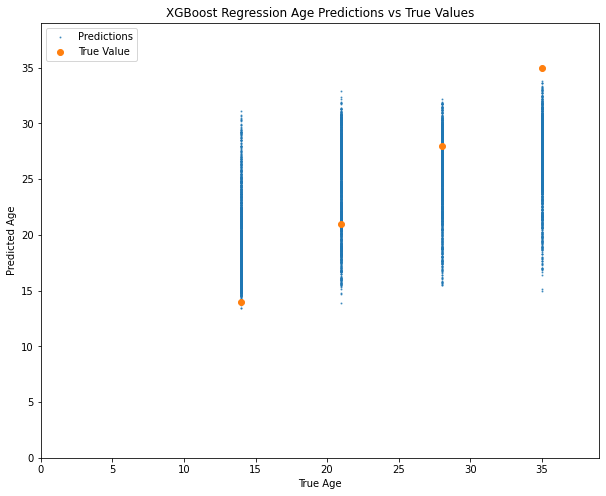

In [158]:
plt.figure(figsize=(10,8))
plt.scatter(x=true_label, y=ypred, Label='Predictions', alpha=0.7, s=1)
plt.scatter(x=[14, 21, 28, 35], y=[14, 21, 28, 35], Label='True Value')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('XGBoost Regression Age Predictions vs True Values')
plt.legend(loc='upper left')
plt.xlim(0,39)
plt.ylim(0,39)
plt.show()

In [80]:
explainer = shap.TreeExplainer(booster) #using booster instead of bst
shap_values = explainer.shap_values(X_test[features])
shap_values

array([[ 7.18248338e-02, -1.89087659e-01, -5.11666387e-02, ...,
        -1.39727101e-01,  1.69881129e+00, -1.19031869e-01],
       [-7.82029033e-02,  1.13575734e-01, -8.09558630e-02, ...,
         1.65810466e-01, -4.59880543e+00, -6.30372614e-02],
       [ 2.29522400e-02, -5.36160404e-03,  3.21040712e-02, ...,
         1.04731691e+00,  3.44902945e+00,  1.06667399e+00],
       ...,
       [-2.81535857e-03,  9.12091210e-02, -8.42718855e-02, ...,
        -1.54633448e-01,  2.53915381e+00, -1.26971155e-01],
       [ 4.14923429e-02, -8.09436291e-02, -2.44113505e-02, ...,
         1.05171371e+00,  1.92246926e+00, -1.18924186e-01],
       [ 6.15277030e-02,  4.02960330e-02,  8.50394145e-02, ...,
        -2.56934077e-01,  2.43557596e+00, -1.35451809e-01]], dtype=float32)

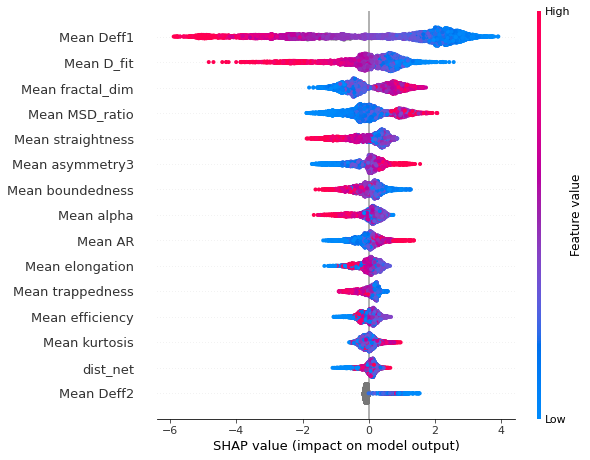

In [83]:
%matplotlib inline


shap.summary_plot(shap_values, X_test[features], max_display=15, title='Total SHAP Values')

TRYING LINEAR REGRESSIONS


In [120]:
# lin_X_train = X_train[shap_features].dropna()
# print(len(lin_X_train))
# nan = lin_X_train.dropna()
# print(len(nan))

linear_columns = [
    'Mean Deff1',
    'Mean D_fit',
    'Mean fractal_dim',
    'Mean MSD_ratio',
    'Mean kurtosis',
    'Mean straightness',
    'age'
    ]

linear_features = [
    'Mean Deff1',
    'Mean D_fit',
    'Mean fractal_dim',
    'Mean MSD_ratio',
    'Mean kurtosis',
    'Mean straightness'
    ]


d_lin = X_train[linear_columns]
train_lin = df_lin.dropna()
test_lin = X_test_val[linear_columns]
test_lin = test_lin.dropna()

In [137]:
# Correlation plot of diffusion data
plt.figure(figsize=(24,10))
cor = bal_ecm[features].corr()
#sn.heatmap(cor, annot=True, cmap=plt.cm.autumn)
#plt.show()

<Figure size 1728x720 with 0 Axes>

In [128]:
linear_model = LinearRegression()
linear_model.fit(train_lin[linear_features], train_lin['age'])

lin_preds = linear_model.predict(test_lin[linear_features])
mse_lin = metrics.mean_squared_error(y_true=test_lin['age'], y_pred=lin_preds)
score = metrics.r2_score(y_true=test_lin['age'], y_pred=lin_preds)
score

0.2700713178879658

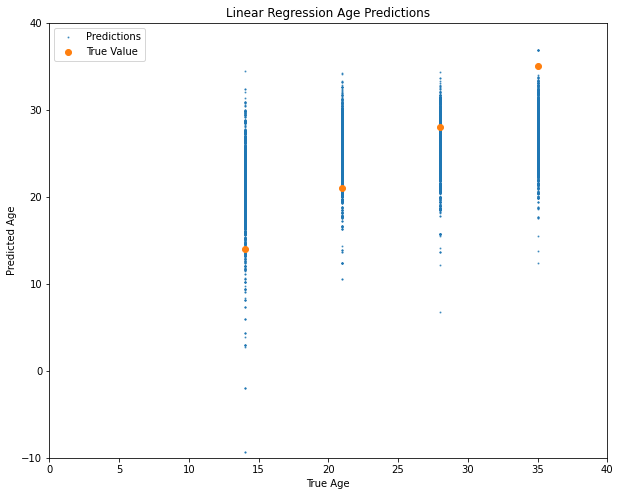

In [156]:
plt.figure(figsize=(10,8))
plt.scatter(x=test_lin['age'], y=lin_preds, Label='Predictions', alpha=0.7, s=1)
plt.scatter(x=[14, 21, 28, 35], y=[14, 21, 28, 35], Label='True Value')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Linear Regression Age Predictions')
plt.legend(loc='upper left')
plt.xlim(0,40)
plt.ylim(-10,40)
plt.show()